In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
image_paths = [
    ('img/l1.png', 'img/r1.png'),
    ('img/l2.png', 'img/r2.png'),
    ('img/l3.png', 'img/r3.png'),
]

In [5]:
WINDOW_SIZES = [1, 5, 9]
DISPARITY_RANGE = 16

In [6]:
def load_images(left_img_path, right_img_path):
    left = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
    right = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)
    return left, right

In [7]:
def sad(left_patch, right_patch):
    return np.sum(np.abs(left_patch - right_patch))

def ssd(left_patch, right_patch):
    return np.sum((left_patch - right_patch) ** 2)

In [8]:
def block_matching(left, right, window_size, method, disparity_range=DISPARITY_RANGE):
    h, w = left.shape
    disparity_map = np.zeros((h, w), dtype=np.uint8)
    half_w = window_size // 2

    for y in tqdm(range(half_w, h - half_w) , desc="Block matching ({method}, w={window_size})"):
        for x in range(half_w, w - half_w):
            min_cost = float('inf')
            best_disparity = 0
            for d in range(disparity_range):
                if x - d - half_w < 0:
                    continue
                left_patch = left[y - half_w:y + half_w + 1, x - half_w:x + half_w + 1]
                right_patch = right[y - half_w:y + half_w + 1, x - d - half_w:x - d + half_w + 1]
                cost = method(left_patch, right_patch)
                if cost < min_cost:
                    min_cost = cost
                    best_disparity = d
            disparity_map[y, x] = best_disparity * (255 // disparity_range)
    return disparity_map

In [ ]:
def visualize_disparity_maps(disparity_maps, titles, cmap='hot'):
    n = len(disparity_maps)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1:
        axes = [axes]
    for i, (disp_map, title) in enumerate(zip(disparity_maps, titles)):
        if np.max(disp_map) > 0:
            disp_vis = (disp_map / np.max(disp_map) * 255).astype(np.uint8)
        else:
            disp_vis = disp_map
            
        im = axes[i].imshow(disp_vis, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig

In [ ]:
img_id = 0
disparity_maps = []
titles = []
left, right = load_images(image_paths[img_id][0],image_paths[img_id][1])
for w in WINDOW_SIZES:
    print(f'Computing disparity map for window size {w}...')
    print('SAD method...')
    sad_map = block_matching(left, right, w, sad)
    print('SSD method...')
    ssd_map = block_matching(left, right, w, ssd)
    cv2.imwrite(f'disparity/disparity_imag_{img_id}_sad_w{w}.png', sad_map)
    cv2.imwrite(f'disparity/disparity_imag_{img_id}_ssd_w{w}.png', ssd_map)
    disparity_maps.append(sad_map)
    titles.append(f'Image {img_id} SAD w={w}')
    disparity_maps.append(ssd_map)
    titles.append(f'Image {img_id} SSD w={w}')



Computing disparity map for window size 1...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 289/289 [00:11<00:00, 26.27it/s]


SSD method...


Block matching ({method}, w={window_size}): 100%|██████████| 289/289 [00:10<00:00, 28.73it/s]


Computing disparity map for window size 5...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 285/285 [00:11<00:00, 24.21it/s]


SSD method...


Block matching ({method}, w={window_size}): 100%|██████████| 285/285 [00:11<00:00, 23.83it/s]


Computing disparity map for window size 9...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 281/281 [00:11<00:00, 24.91it/s]


SSD method...


Block matching ({method}, w={window_size}): 100%|██████████| 281/281 [00:11<00:00, 24.28it/s]


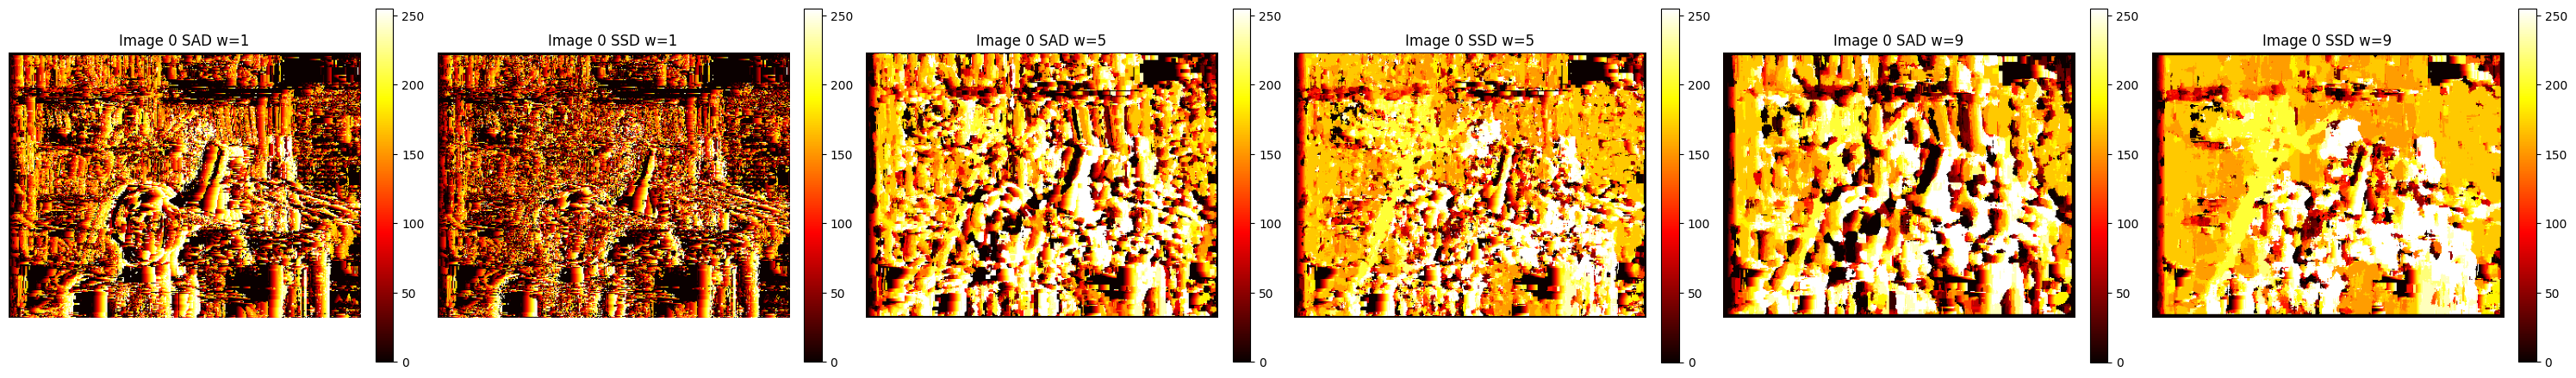

In [32]:
fig = visualize_disparity_maps(disparity_maps, titles, cmap='hot')
fig.savefig("disparity/block_matching_results.png")
plt.show()
plt.close(fig)

In [36]:
def plot_alignment_path(path, n):
    i, j = n-1, n-1
    align_path = [(i, j)]
    while i > 0 or j > 0:
        if path[i, j] == 0:   
            i -= 1
            j -= 1
        elif path[i, j] == 1:   
            i -= 1
        else:   
            j -= 1
        align_path.append((i, j))
    return align_path[::-1]   

In [38]:
def dynamic_programming_stereo(left_img, right_img, sigma=2, c0=1):
    h, w = left_img.shape[:2]
    left_disparity_map = np.zeros((h, w), dtype=np.float32)
    right_disparity_map = np.zeros((h, w), dtype=np.float32)
    for y in tqdm(range(h), desc="Dynamic programming"):
        left_scanline = left_img[y, :].astype(float)
        right_scanline = right_img[y, :].astype(float)
        d_ij = [(left_scanline[i] - right_scanline[j]) ** 2 / (sigma ** 2) 
                for i in range(w) for j in range(w)]
        d_ij = np.array(d_ij).reshape((w, w))
        D = np.zeros((w , w ), dtype=float)
        path = np.zeros((w , w ), dtype=np.int32) 
        D[0, 0] = d_ij[0, 0]
        for j in range(1, w ):
            D[0, j] = D[0, j-1] + c0
            path[0, j] = 2  
        for i in range(1, w ):
            D[i, 0] = D[i-1, 0] + c0
            path[i, 0] = 1   
        for i in range(1, w ):
            for j in range(1, w ):
                cost_diag = D[i-1, j-1] + d_ij[i, j]   
                cost_left = D[i, j-1] + c0   
                cost_up = D[i-1, j] + c0   
                min_cost = min(cost_diag, cost_left, cost_up)
                D[i, j] = min_cost 
                if min_cost == cost_diag:
                    path[i, j] = 0   
                elif min_cost == cost_left:
                    path[i, j] = 2   
                else:
                    path[i, j] = 1   

        i, j = w-1, w-1
        while i > 0 or j > 0:
            if path[i, j] == 0:   
                left_disparity_map[y, i] = abs(i - j) * (255 // 16)
                right_disparity_map[y, j] = abs(i - j) * (255 // 16)
                i -= 1
                j -= 1
            elif path[i, j] == 1:   
                left_disparity_map[y, i] = 0   
                i -= 1
            else:   
                right_disparity_map[y, j] = 0   
                j -= 1
        alignment_path = plot_alignment_path(path, w)
    return left_disparity_map, right_disparity_map, alignment_path

In [18]:
def visualize_alignment(alignment_path, y):
    fig, ax = plt.subplots(figsize=(8, 8))
    path_arr = np.array(alignment_path)
    ax.plot(path_arr[:, 1], path_arr[:, 0], 'b-', linewidth=2)
    ax.plot(path_arr[0, 1], path_arr[0, 0], 'go', markersize=10)
    ax.plot(path_arr[-1, 1], path_arr[-1, 0], 'ro', markersize=10)
    
    ax.set_xlabel('Right Image Index')
    ax.set_ylabel('Left Image Index')
    ax.set_title(f'Alignment Path for Scanline y={y}')
    ax.grid(True)
    
    return fig

Dynamic programming: 100%|██████████| 289/289 [01:09<00:00,  4.15it/s]


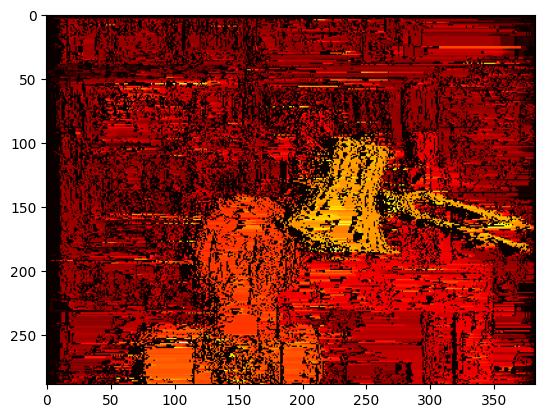

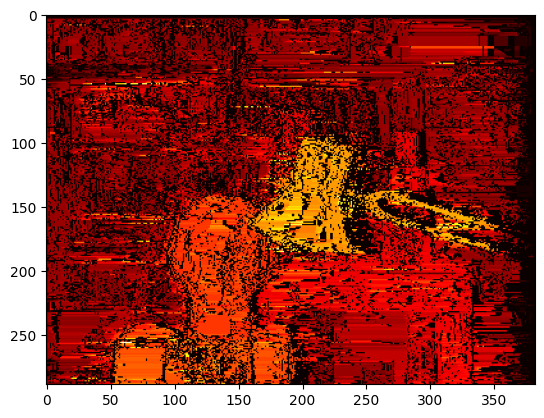

Dynamic programming: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


In [39]:

img_id = 0
left_img, right_img = load_images(image_paths[img_id][0], image_paths[img_id][1])
left_disparity_map, right_disparity_map, alignment_path = dynamic_programming_stereo(left_img, right_img)

cv2.imwrite(f'disparity/disparity_imag_{img_id}_dp_left.png', left_disparity_map)
cv2.imwrite(f'disparity/disparity_imag_{img_id}_dp_right.png', right_disparity_map)

plt.imshow(left_disparity_map, cmap='hot')
plt.show()
plt.imshow(right_disparity_map, cmap='hot')
plt.show()

fig_dp = visualize_disparity_maps([left_disparity_map, right_disparity_map], 
                                    ["DP Left Disparity", "DP Right Disparity"])
fig_dp.savefig("disparity/dynamic_programming_results.png")
plt.close(fig_dp)


y_sample = left_img.shape[0] // 2
_, _, scanline_path = dynamic_programming_stereo(
    left_img[y_sample:y_sample+1, :], 
    right_img[y_sample:y_sample+1, :]
)
fig_align = visualize_alignment(scanline_path, y_sample)
fig_align.savefig("disparity/alignment_path.png")
plt.close(fig_align)

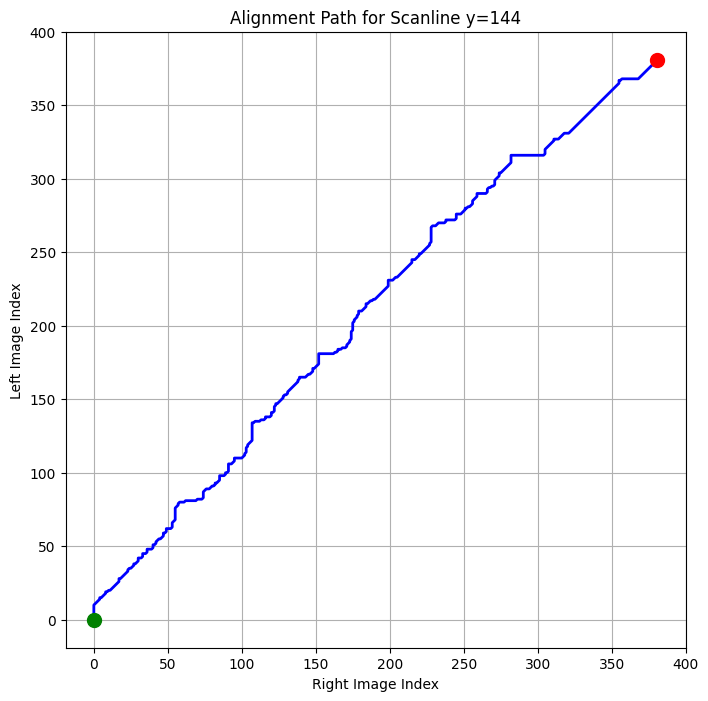

In [40]:
fig_align

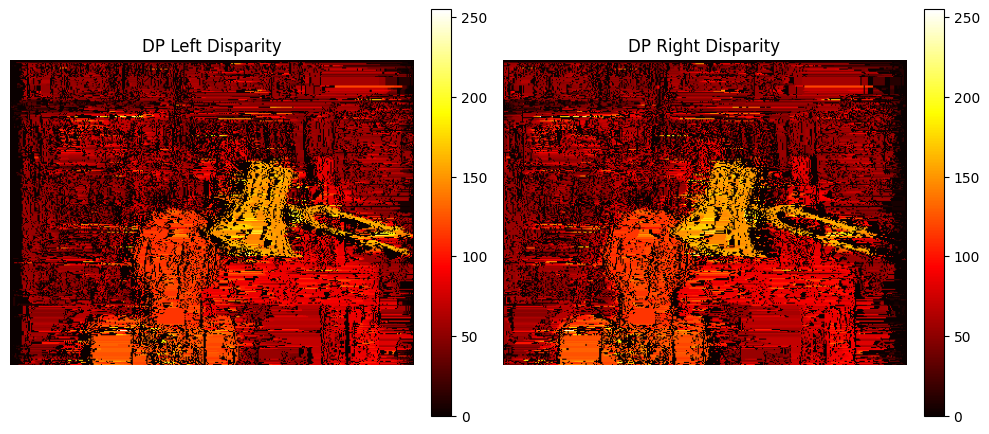

In [24]:
fig_dp


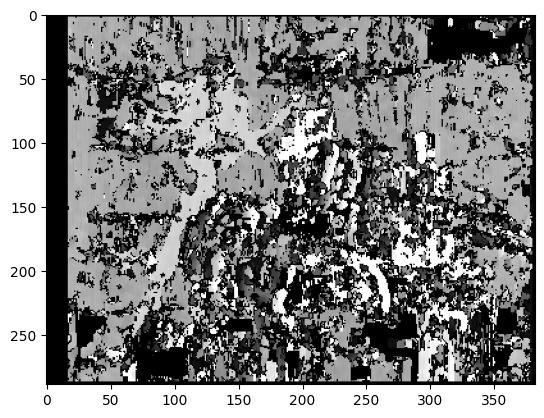

In [ ]:
stereo = cv2.StereoBM.create(numDisparities=16, blockSize=5)
disparity = stereo.compute(left_img, right_img)
plt.imshow(disparity,'gray')
plt.show()

In [30]:
# rest of the images
for img_id in tqdm(range(1, len(image_paths)), desc="Processing images"):
    left, right = load_images(image_paths[img_id][0],image_paths[img_id][1])

    # Block matching stereo
    for w in WINDOW_SIZES:
        print(f'Computing disparity map for window size {w}...')
        print('SAD method...')
        sad_map = block_matching(left, right, w, sad)
        print('SSD method...')
        ssd_map = block_matching(left, right, w, ssd)
        cv2.imwrite(f'disparity/disparity_imag_{img_id}_sad_w{w}.png', sad_map)
        cv2.imwrite(f'disparity/disparity_imag_{img_id}_ssd_w{w}.png', ssd_map)

    # Dynamic programming stereo
    left_disparity_map, right_disparity_map, _ = dynamic_programming_stereo(left, right)
    cv2.imwrite(f'disparity/disparity_imag_{img_id}_dp_left.png', left_disparity_map)
    cv2.imwrite(f'disparity/disparity_imag_{img_id}_dp_right.png', right_disparity_map)


Processing images:   0%|          | 0/2 [00:00<?, ?it/s]

Computing disparity map for window size 1...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 375/375 [00:14<00:00, 25.39it/s]


SSD method...


Block matching ({method}, w={window_size}): 100%|██████████| 375/375 [00:33<00:00, 11.18it/s]


Computing disparity map for window size 5...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 371/371 [00:35<00:00, 10.54it/s]


SSD method...


Block matching ({method}, w={window_size}): 100%|██████████| 371/371 [00:31<00:00, 11.61it/s]


Computing disparity map for window size 9...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 367/367 [00:42<00:00,  8.64it/s]


SSD method...


Processing images:  50%|█████     | 1/2 [06:15<06:15, 375.34s/it]

Computing disparity map for window size 1...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 375/375 [00:26<00:00, 14.38it/s]


SSD method...


Block matching ({method}, w={window_size}): 100%|██████████| 375/375 [00:29<00:00, 12.86it/s]


Computing disparity map for window size 5...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 371/371 [00:40<00:00,  9.07it/s]


SSD method...


Block matching ({method}, w={window_size}): 100%|██████████| 371/371 [00:37<00:00,  9.77it/s]


Computing disparity map for window size 9...
SAD method...


Block matching ({method}, w={window_size}): 100%|██████████| 367/367 [00:37<00:00,  9.80it/s]


SSD method...


Processing images: 100%|██████████| 2/2 [12:38<00:00, 379.06s/it]
